In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import text

#clemens access

url1 = "datafiles/df_final_demo.txt"
url2 = "datafiles/df_final_web_data_pt_1.txt"
url3 = "datafiles/df_final_web_data_pt_2.txt"
url4 = "datafiles/df_final_experiment_clients.txt"
df_final_demo = pd.read_csv(url1)
df_final_demo
df_final_web_data_pt_1 = pd.read_csv(url2)
df_final_web_data_pt_1
df_final_web_data_pt_2 = pd.read_csv(url3)
df_final_web_data_pt_2
df_final_web_data = pd.concat([df_final_web_data_pt_1, df_final_web_data_pt_2], axis=0, join='outer', ignore_index=True)
df_final_web_data
df_final_experiment_clients = pd.read_csv(url4)
df_final_experiment_clients
df_fwd_san=pd.read_csv("datafiles/df_fwd_steps_as_numbers.csv")



#add stepchange column. it is false if the step is the same as the last and the visit_id is the same as the last

def addstepchange(df):
  df['prev_process_step'] = df['process_step'].shift(1)
  df['prev_visit_id'] = df['visit_id'].shift(1)
  df['step_change'] = np.where(df['visit_id'] == df['prev_visit_id'],
                                 df['process_step'] - df['prev_process_step'],
                                 np.nan)
  df = df.drop(columns=['prev_process_step', 'prev_visit_id'])
  return df




#calculate error rate. The amount of steps where the visit didn't progress as a proportion of total visits
#merge ab test info
def addtestinfo(df):
  df=pd.merge(df, df_final_experiment_clients, on="client_id")
  return df

def adderrorbool(df):
  df['iserror'] = df_stepsort['step_change'] < 1
  return df

def calc_error_rate(df):
  n_visits=df["visit_id"].count()
  n_errors=df["iserror"].sum()
  return n_errors/n_visits



In [ ]:
df_stepsort=df_fwd_san.sort_values(by=["client_id","visitor_id","visit_id","date_time"])
df_stepsort=df_fwd_san.sort_values(by=["client_id","visitor_id","visit_id","date_time"])
df_stepsort=addstepchange(df_stepsort)
df_stepsort=adderrorbool(df_stepsort)
df_abtest=pd.merge(df_stepsort, df_final_experiment_clients, on="client_id")




In [ ]:
df_stepsort

,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,step_change,iserror
285515,285515,169,201385055_71273495308,749567106_99161211863_557568,0,2017-04-12 20:19:36,NaN,False
285514,285514,169,201385055_71273495308,749567106_99161211863_557568,1,2017-04-12 20:19:45,1.0,False
285513,285513,169,201385055_71273495308,749567106_99161211863_557568,2,2017-04-12 20:20:31,1.0,False
285512,285512,169,201385055_71273495308,749567106_99161211863_557568,3,2017-04-12 20:22:05,1.0,False
285511,285511,169,201385055_71273495308,749567106_99161211863_557568,4,2017-04-12 20:23:09,1.0,False
...,...,...,...,...,...,...,...,...
648533,648533,9999875,738878760_1556639849,931268933_219402947_599432,1,2017-06-01 22:40:08,1.0,False
648532,648532,9999875,738878760_1556639849,931268933_219402947_599432,1,2017-06-01 22:41:28,0.0,True
648531,648531,9999875,738878760_1556639849,931268933_219402947_599432,2,2017-06-01 22:41:47,1.0,False
648530,648530,9999875,738878760_1556639849,931268933_219402947_599432,3,2017-06-01 22:44:58,1.0,False


In [ ]:
df_stepsort.groupby(["step_change"]).count()


,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,iserror
step_change,,,,,,,
-4.0,1106,1106,1106,1106,1106,1106,1106
-3.0,8819,8819,8819,8819,8819,8819,8819
-2.0,7585,7585,7585,7585,7585,7585,7585
-1.0,45450,45450,45450,45450,45450,45450,45450
0.0,87887,87887,87887,87887,87887,87887,87887
1.0,442693,442693,442693,442693,442693,442693,442693
2.0,1379,1379,1379,1379,1379,1379,1379
3.0,1248,1248,1248,1248,1248,1248,1248
4.0,126,126,126,126,126,126,126


In [ ]:
print(calc_error_rate(df_stepsort))

0.19969023239189573


In [ ]:
#Hypotheis testing the error rate
#H0: Both the test and the control group have the same error rate
#alpha = 0.05

from scipy.stats import chi2_contingency
#first create a crosstab
crosstab_result_err = pd.crosstab(df_abtest['iserror'], df_abtest['Variation'])

crosstab_result_err
# Chi-square test for 'Variation' and 'iserror'


chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result_err)

chi2_statistic, chi2_p_value

(247.72901458390214, 8.119772280346216e-56)

In [ ]:
#Based on an alpha of 0.05, we can reject the null Hypothesis. The Test is unlikely
#to not have an effect on the error rate


In [ ]:
# Hypothesis Testing:
#H0: Completion rate and Test Variation are independent
#count all the steps each user managed to do

df_counts=pd.DataFrame()
df=df_abtest
df_counts["client_id"]=df[df["process_step"]==0]["client_id"]
df_counts["step_0"]=True


step_1_clients = df[df["process_step"] == 1]["client_id"].unique()
df_counts['step_1'] = df_counts['client_id'].isin(step_1_clients)

step_2_clients = df[df["process_step"] == 2]["client_id"].unique()
df_counts['step_2'] = df_counts['client_id'].isin(step_2_clients)


step_3_clients = df[df["process_step"] == 3]["client_id"].unique()
df_counts['step_3'] = df_counts['client_id'].isin(step_3_clients)


step_4_clients = df[df["process_step"] == 4]["client_id"].unique()
df_counts['step_4'] = df_counts['client_id'].isin(step_4_clients)

df_counts=pd.merge(df_counts, df_final_experiment_clients, on="client_id")


In [ ]:
df_counts

,client_id,step_0,step_1,step_2,step_3,step_4,Variation
0,169,True,True,True,True,True,NaN
1,555,True,True,True,True,True,Test
2,647,True,True,True,True,True,Test
3,722,True,True,True,True,True,NaN
4,722,True,True,True,True,True,NaN
...,...,...,...,...,...,...,...
145583,9999729,True,True,True,True,True,Test
145584,9999729,True,True,True,True,True,Test
145585,9999832,True,True,False,False,False,Test
145586,9999839,True,True,True,True,True,NaN


In [ ]:
#create a crosstab:

crosstab_result_cr = pd.crosstab(df_counts['step_4'], df['Variation'])

crosstab_result_cr

Variation,Control,Test
step_4,,
False,17352,21997
True,28813,35643


In [ ]:
#H0: The Test Variation has no influence on the completion rate


# Chi-square test for 'step_4' and 'Variation'
chi2_statistic_cr, chi2_p_value_cr, _, _ = chi2_contingency(crosstab_result_cr)

chi2_statistic_cr, chi2_p_value_cr

(3.586582529242129, 0.0582479126697753)

In [ ]:
#Based on an alpha of 0.05, we cannot reject the zero hypothesis.
#It seems we cannot assume, that the test had an influence on the conversion rate
#in connection with the other result, we could say that the interface has
#gotten easier to navigate, but it has not made people overall more likely
#to make a deposit. Maybe people willing to deposit money into a savings account
#aren't as easily deterred from completion by a slightly harder interface



In [ ]:
#Third Hypothesis:
#Client Age has no impact on error rate

#add an age column to the df_abtest

df_abtest_age=pd.merge(df_abtest, df_final_demo, on="client_id")
df_abtest_age


,Unnamed: 0,client_id,visitor_id,visit_id,process_step,date_time,step_change,iserror,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,285515,169,201385055_71273495308,749567106_99161211863_557568,0,2017-04-12 20:19:36,NaN,False,NaN,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0
1,285514,169,201385055_71273495308,749567106_99161211863_557568,1,2017-04-12 20:19:45,1.0,False,NaN,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0
2,285513,169,201385055_71273495308,749567106_99161211863_557568,2,2017-04-12 20:20:31,1.0,False,NaN,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0
3,285512,169,201385055_71273495308,749567106_99161211863_557568,3,2017-04-12 20:22:05,1.0,False,NaN,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0
4,285511,169,201385055_71273495308,749567106_99161211863_557568,4,2017-04-12 20:23:09,1.0,False,NaN,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449826,274435,9999839,948322592_28990736246,715530422_68620416793_515645,0,2017-03-29 12:11:32,0.0,True,NaN,13.0,160.0,28.5,F,2.0,67425.35,3.0,3.0
449827,274434,9999839,948322592_28990736246,715530422_68620416793_515645,1,2017-03-29 12:11:35,1.0,False,NaN,13.0,160.0,28.5,F,2.0,67425.35,3.0,3.0
449828,274433,9999839,948322592_28990736246,715530422_68620416793_515645,2,2017-03-29 12:11:50,1.0,False,NaN,13.0,160.0,28.5,F,2.0,67425.35,3.0,3.0
449829,274432,9999839,948322592_28990736246,715530422_68620416793_515645,3,2017-03-29 12:12:28,1.0,False,NaN,13.0,160.0,28.5,F,2.0,67425.35,3.0,3.0


In [ ]:
from scipy.stats import ttest_ind

,0
Unnamed: 0,int64
client_id,int64
visitor_id,object
visit_id,object
process_step,int64
date_time,object
step_change,float64
iserror,bool
Variation,object
clnt_tenure_yr,float64


In [ ]:
df_error=df_abtest_age[df_abtest_age["iserror"]]
df_noterror=df_abtest_age[df_abtest_age["iserror"]==False]
ttest_ind(df_error["clnt_age"],df_noterror["clnt_age"], equal_var=False)

TtestResult(statistic=nan, pvalue=nan, df=nan)

In [ ]:
ttest_ind(df_error["clnt_age"].dropna(), df_noterror["clnt_age"].dropna(), equal_var=False)

TtestResult(statistic=47.412686749970675, pvalue=0.0, df=132695.77206980155)

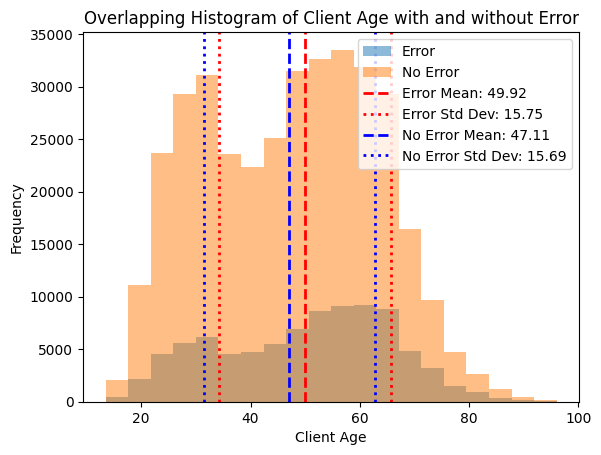

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df_error' and 'df_noterror' are defined with your data...
plt.hist(df_error["clnt_age"].dropna(), bins=20, alpha=0.5, label="Error")
plt.hist(df_noterror["clnt_age"].dropna(), bins=20, alpha=0.5, label="No Error")

plt.xlabel("Client Age")
plt.ylabel("Frequency")
plt.title("Overlapping Histogram of Client Age with and without Error")

# Calculate mean and standard deviation for each group
mean_error = np.mean(df_error["clnt_age"].dropna())
std_error = np.std(df_error["clnt_age"].dropna())
mean_no_error = np.mean(df_noterror["clnt_age"].dropna())
std_no_error = np.std(df_noterror["clnt_age"].dropna())

# Add vertical lines for mean and standard deviations
plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f"Error Mean: {mean_error:.2f}")
plt.axvline(mean_error + std_error, color='red', linestyle='dotted', linewidth=2, label=f"Error Std Dev: {std_error:.2f}")
plt.axvline(mean_error - std_error, color='red', linestyle='dotted', linewidth=2)

plt.axvline(mean_no_error, color='blue', linestyle='dashed', linewidth=2, label=f"No Error Mean: {mean_no_error:.2f}")
plt.axvline(mean_no_error + std_no_error, color='blue', linestyle='dotted', linewidth=2, label=f"No Error Std Dev: {std_no_error:.2f}")
plt.axvline(mean_no_error - std_no_error, color='blue', linestyle='dotted', linewidth=2)

plt.legend()
plt.show()